In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
from PIL import ImageFont

In [2]:
%matplotlib inline
mpl.style.use('seaborn')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import tensorflow as tf

In [6]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

cs_lo_k = {
            'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1
          }

br_ratio = {
            'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1
          }

cs_nmg = {
         'ttbar':393.30,
         'wmp'  :7.865*1e4,
         'wpwm' :74.96,
         'zwpm' :14.28,
         'n2n2' :1
         }

cs_mg = {'ttbar':5.883,
          'wmp':111.5,
          'wpwm':0.944,
          'zwpm':0.2381,
          'n2n2':3.99*1e-4
        }

cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
#k_f = [1.954,1.356,1.92,2.09,1.0]

cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [7]:
cs_corr

{'ttbar': 6538.845366086956,
 'wmp': 91227.27272727272,
 'wpwm': 692.2567850586979,
 'zwpm': 199.5908264705882,
 'n2n2': 0.399}

In [8]:
df = []
for f in range(len(files)):
    con_df = []
    
    for i in range(1,11):
        con_df.append(pd.read_csv('~/datasets/comp/' + files[f] + str(i) + '.csv'))
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

In [9]:
df[-1].head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,576.562,0.232894,592.269,459.681,0.248122,475.279,36.1316,379.243,1.14509,2.253050,889.067,0.190804,0.258472,0.517955,0.670891,769.506,1.86471,4,1
1,823.599,-0.418800,896.887,339.247,-0.696095,431.789,77.3122,1052.580,2.67178,2.072780,1930.330,0.197178,0.222316,0.468612,0.544453,1113.560,1.81712,4,1
2,354.758,-1.721930,1024.200,883.807,-0.817714,1200.200,98.7750,1764.850,2.82048,0.922735,3256.570,0.328865,0.361102,0.409280,0.760725,1015.050,2.09248,4,1
3,858.275,0.386685,923.245,1258.810,0.184948,1285.290,112.0150,1546.480,1.12283,2.551460,388.116,0.216487,0.234383,0.308864,0.722296,510.332,2.04593,4,1
4,590.040,-0.006999,590.055,811.602,0.445120,897.952,90.8938,818.864,1.16291,1.495500,1133.330,0.172456,0.329166,0.461283,0.696238,351.882,3.21196,4,1


In [10]:
dtset = pd.concat(df,ignore_index=True)
dtset = shuffle(dtset)
dtset['met'] = np.fabs(dtset['met'])

In [11]:
## Analysis Level Cuts
dtset = dtset[dtset['ptl'] >= 120.0][dtset['ptj'] >= 120.0][dtset['etaj'] <= 2.0][dtset['etaj'] >= -2.0]

In [12]:
dtset.head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
2328116,166.813,0.279813,173.386,254.230,0.352519,271.790,29.4395,404.557,3.05915,0.437055,368.590,0.231744,0.302312,0.362637,0.407019,170.818,2.881140,3,0
298656,172.337,-1.449760,387.474,215.413,-0.650419,262.890,12.2127,276.733,2.32963,3.024540,2232.060,0.183070,0.433707,0.465962,0.540611,198.450,1.928980,0,0
1071065,241.458,-1.540570,589.341,315.713,-1.008730,491.203,27.5480,235.939,2.22513,0.571852,1082.930,0.000000,0.353036,0.646715,0.882511,159.273,1.871430,1,0
168264,235.601,1.960780,853.532,607.401,0.524314,710.457,157.3240,642.090,2.96183,1.453670,1491.500,0.129236,0.322998,0.358928,0.644124,170.036,0.202586,0,0
131067,156.873,-0.118152,157.970,141.430,-1.023620,222.570,12.3802,223.188,2.16313,3.256590,35.294,0.023580,0.202986,0.180170,0.477805,199.383,3.183400,0,0


In [13]:
train_len = int(0.8*len(dtset))
x_train = dtset.T[:-2].T[:train_len]
y_train = dtset['tag'][:train_len]

x_test = dtset.T[:-2].T[train_len:]
y_test = dtset['tag'][train_len:]

print('Shapes : ',x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Shapes :  (2296690, 17) (2296690,) (574173, 17) (574173,)


In [14]:
model = Sequential()
input_shape = x_train.shape

from keras.layers.normalization.batch_normalization import BatchNormalization
model.add(Dense(10,activation = 'relu',input_dim = input_shape[1]))
model.add(BatchNormalization())
model.add(Dense(25,activation = 'relu',input_dim = 10))
model.add(BatchNormalization())
model.add(Dense(40,activation = 'relu',input_dim = 25))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 40))
model.add(BatchNormalization())
model.add(Dense(12,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(8,activation = 'relu',input_dim = 12))
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid',input_dim = 8))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

2022-03-28 19:40:27.118843: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-28 19:40:27.118921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gnode51
2022-03-28 19:40:27.118931: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gnode51
2022-03-28 19:40:27.119160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.118.2
2022-03-28 19:40:27.119208: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.118.2
2022-03-28 19:40:27.119216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.118.2
2022-03-28 19:40:27.135421: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in

In [35]:
model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2,class_weight={0:.99,1:0.01})

Epoch 1/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0064 - accuracy: 0.8257 - val_loss: 0.3762 - val_accuracy: 0.8485
Epoch 2/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0063 - accuracy: 0.8268 - val_loss: 0.4261 - val_accuracy: 0.8238
Epoch 3/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0063 - accuracy: 0.8265 - val_loss: 0.4170 - val_accuracy: 0.8306
Epoch 4/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0063 - accuracy: 0.8290 - val_loss: 0.3654 - val_accuracy: 0.8471
Epoch 5/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0063 - accuracy: 0.8294 - val_loss: 0.4675 - val_accuracy: 0.8187
Epoch 6/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0063 - accuracy: 0.8293 - val_loss: 0.3712 - val_accuracy: 0.8527
Epoch 7/10
14355/14355 [==============================] - 36s 2ms/step - loss: 0.0063 - accuracy: 0.8292 - val_loss: 0

In [36]:
tot_pred = model.predict(dtset.T[:-2].T)

In [37]:
pred_set = dtset.copy()
pred_set['pred'] = tot_pred

In [38]:
cor_pred = len(pred_set[train_len:][pred_set['pred'] >= 0.5][pred_set['tag'] == 1]) + len(pred_set[train_len:][pred_set['pred'] < 0.5][pred_set['tag'] == 0])
print('The accuracy of the test set is : ',cor_pred/(len(pred_set[train_len:])))

The accuracy of the test set is :  0.834579473433965


In [39]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  338105
Falsely identified signal (Flase Positive)      :  1174
Correctly identified background (True Negative) :  2057912
Falsely identified background (False Negative)  :  473672


In [40]:
print('The amount of signal left is     :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/len(df[-1]))
print('The amount of background left is :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0])/np.sum([len(i) for i in df[:-1]]))

The amount of signal left is     : 0.39959698149778694
The amount of background left is : 0.0004783490032698047


In [41]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= 0.5][dtset['tag'] == 1])/(len(pred_set[pred_set['pred'] >= 0.5])))

Thus, the rate of correct signal prediction is :  0.9965397209965839


In [42]:
L = 3000

In [45]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])/(1e6))*L
print('n2n2',cs_corr['n2n2'],(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])))
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i])/((1e6)))*L
    print(files[i],len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 0.399 224090
ttbar 5 6538.845366086956
wmp 30 91227.27272727272
wpwm 163 692.2567850586979
zwpm 185 199.5908264705882


In [46]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb))

The number of signal is : 268.23573000000005
The number of background is : 8757.823702530732
The significance is : 2.86627943545068


In [24]:
model.save('/home2/kalp_shah/datasets/models/s4')

2022-03-28 12:42:52.648281: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home2/kalp_shah/datasets/models/s4/assets


In [28]:
import tensorflow_probability as tfp
cor = tfp.stats.correlation(dtset.values[:-2,:-2])

In [29]:
for i in range(len(cor)):
    for j in range(len(cor[i])):
        if cor[i,j] > 0.8 and i!=j:
            print(dtset.keys()[i],dtset.keys()[j],cor[i,j].numpy())

ptj energyj 0.8332972254692859
energyj ptj 0.8332972254692859


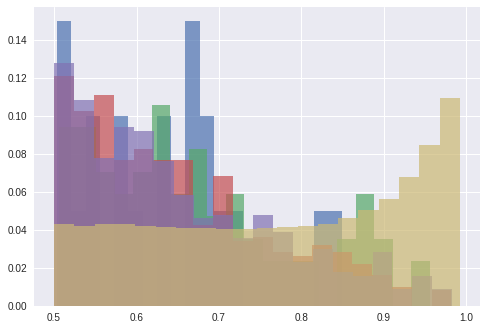

In [65]:
for i in range(len(files)):
    data = pred_set[pred_set["type"] == i][pred_set["pred"]>=0.5]["pred"].values
    plt.hist(data,alpha=0.7,bins=20,weights=np.ones_like(data)/len(data))
plt.show()

In [53]:
pred_set[pred_set["type"] == 0]["pred"].values

array([2.5260133e-06, 9.0794361e-05, 9.8490336e-06, ..., 9.6628992e-07,
       2.2237360e-02, 1.9050436e-05], dtype=float32)